In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
class MarketEnv:
    def __init__(self, P0=100.0, sigma=0.1, dt=1.0, lambda_hit=0.3):
        self.P = P0
        self.sigma = sigma      # volatility per sqrt(dt)
        self.dt = dt
        self.lambda_hit = lambda_hit  # base hit probability

    def step_price(self):
        """Simulate one time step of mid-price movement."""
        eps = np.random.normal(0, self.sigma * np.sqrt(self.dt))
        self.P += eps
        return self.P

    def sample_hits(self, bid_dist, ask_dist):
        """
        Determine whether bid/ask quotes get hit.
        bid_dist: distance of bid from mid-price
        ask_dist: distance of ask from mid-price
        """
        p_bid = self.lambda_hit * np.exp(-bid_dist)
        p_ask = self.lambda_hit * np.exp(-ask_dist)
        return (np.random.rand() < p_bid), (np.random.rand() < p_ask)


In [4]:
class NaiveMM:
    """Constant spread, no inventory control."""
    def __init__(self, spread=0.2, size=1):
        self.spread = spread
        self.size = size
        self.inventory = 0
        self.cash = 0

    def quotes(self, mid_price):
        bid = mid_price - self.spread / 2
        ask = mid_price + self.spread / 2
        return bid, ask

class InventoryAwareMM:
    """Adjust quotes based on inventory."""
    def __init__(self, spread=0.2, size=1, risk_aversion=0.05):
        self.spread = spread
        self.size = size
        self.risk_aversion = risk_aversion
        self.inventory = 0
        self.cash = 0

    def quotes(self, mid_price):
        skew = self.risk_aversion * self.inventory
        bid = mid_price - self.spread / 2 - skew
        ask = mid_price + self.spread / 2 - skew
        return bid, ask


In [5]:
def simulate(env, mm, T=1000):
    records = []
    for t in range(T):
        mid = env.step_price()
        bid, ask = mm.quotes(mid)

        # Distances from mid for hit probability model
        bid_hit, ask_hit = env.sample_hits(mid - bid, ask - mid)

        # Update inventory & cash
        if bid_hit:
            mm.inventory += mm.size
            mm.cash -= bid * mm.size
        if ask_hit:
            mm.inventory -= mm.size
            mm.cash += ask * mm.size

        # Mark-to-market P&L
        mtm = mm.cash + mm.inventory * mid
        records.append({
            't': t, 'mid': mid, 'bid': bid, 'ask': ask,
            'inv': mm.inventory, 'cash': mm.cash, 'mtm': mtm
        })

    return pd.DataFrame(records)


In [6]:
np.random.seed(42)
T = 500

# Naive
env1 = MarketEnv()
mm1 = NaiveMM(spread=0.2)
df_naive = simulate(env1, mm1, T)

# Inventory-aware
env2 = MarketEnv()
mm2 = InventoryAwareMM(spread=0.2, risk_aversion=0.05)
df_inv = simulate(env2, mm2, T)


C:\Users\Aryan\AppData\Local\Temp\ipykernel_18228\2531688918.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


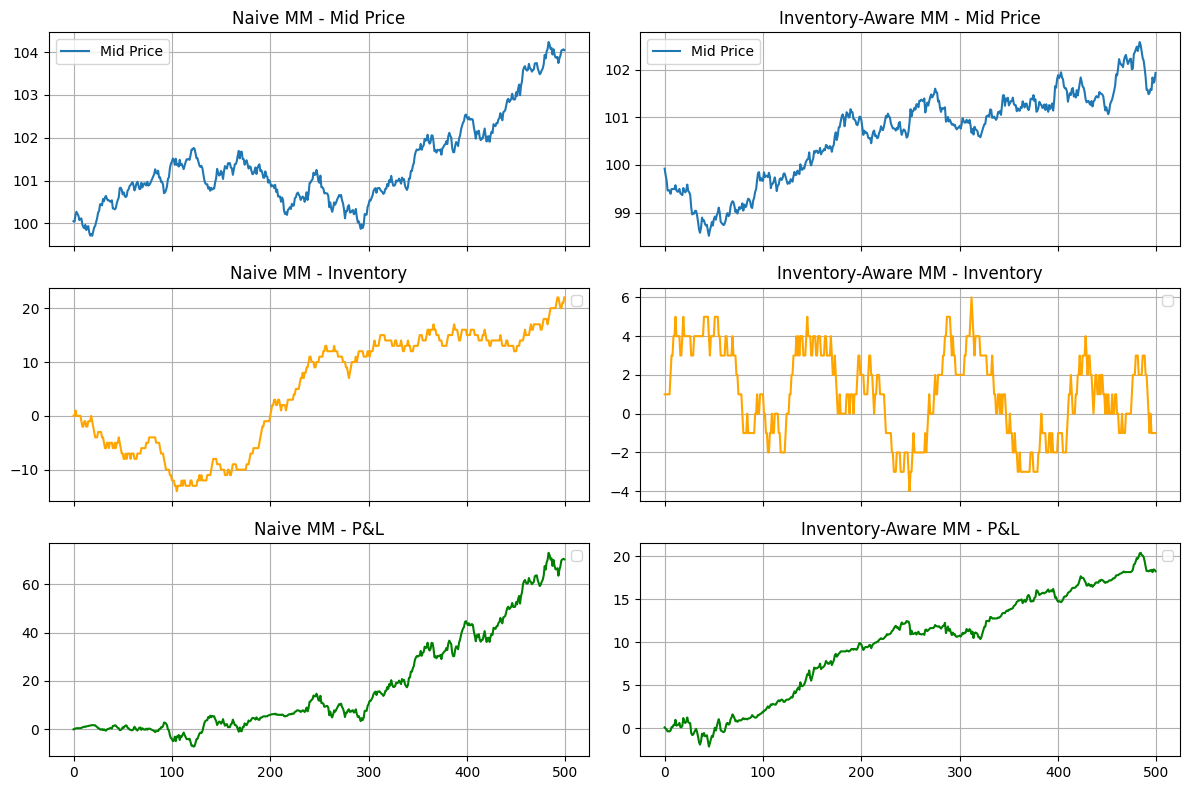

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

# Mid-price
axes[0,0].plot(df_naive['t'], df_naive['mid'], label='Mid Price')
axes[0,0].set_title('Naive MM - Mid Price')
axes[0,1].plot(df_inv['t'], df_inv['mid'], label='Mid Price')
axes[0,1].set_title('Inventory-Aware MM - Mid Price')

# Inventory
axes[1,0].plot(df_naive['t'], df_naive['inv'], color='orange')
axes[1,0].set_title('Naive MM - Inventory')
axes[1,1].plot(df_inv['t'], df_inv['inv'], color='orange')
axes[1,1].set_title('Inventory-Aware MM - Inventory')

# P&L
axes[2,0].plot(df_naive['t'], df_naive['mtm'], color='green')
axes[2,0].set_title('Naive MM - P&L')
axes[2,1].plot(df_inv['t'], df_inv['mtm'], color='green')
axes[2,1].set_title('Inventory-Aware MM - P&L')

for ax in axes.flat:
    ax.grid(True)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()